In [1]:

# importamos las librerías que necesitamos

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
# ------------------------------------------------------------------------------
import scipy.stats as stats

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [24]:
from scipy.stats import ttest_ind, norm, chi2_contingency, f_oneway
from sklearn.linear_model import LinearRegression

In [2]:
df_marketing= pd.read_csv("marketing_AB.csv", index_col=0)

In [3]:
df_marketing

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14
...,...,...,...,...,...,...
588096,1278437,ad,False,1,Tuesday,23
588097,1327975,ad,False,1,Tuesday,23
588098,1038442,ad,False,3,Tuesday,23
588099,1496395,ad,False,1,Tuesday,23


In [4]:
# una vez que tengamos nuestro DataFrame preparado con todas las columnas que queremos vamos a crear una función que no haga una exploración inicial del conjunto de datos
def exploracion_dataframe(dataframe, columna_control):

    print(f"Los duplicados que tenemos en el conjunto de datos son: {dataframe.duplicated().sum()}")
    print("\n ..................... \n")
    
    
    # generamos un DataFrame para los valores nulos
    print("Los nulos que tenemos en el conjunto de datos son:")
    df_nulos = pd.DataFrame(dataframe.isnull().sum() / dataframe.shape[0] * 100, columns = ["%_nulos"])
    display(df_nulos[df_nulos["%_nulos"] > 0])
    
    print("\n ..................... \n")
    print(f"Los tipos de las columnas son:")
    display(pd.DataFrame(dataframe.dtypes, columns = ["tipo_dato"]))
    
    
    print("\n ..................... \n")
    print("Los valores que tenemos para las columnas categóricas son: ")
    dataframe_categoricas = dataframe.select_dtypes(include = "O")
    
    for col in dataframe_categoricas.columns:
        print(f"La columna {col.upper()} tiene las siguientes valore únicos:")
        display(pd.DataFrame(dataframe[col].value_counts()).head())    
    
    # como estamos en un problema de A/B testing y lo que realmente nos importa es comparar entre el grupo de control y el de test, los principales estadísticos los vamos a sacar de cada una de las categorías
    
    for categoria in dataframe[columna_control].unique():
        
        dataframe_filtrado = dataframe[dataframe[columna_control] == categoria]
    
        print("\n ..................... \n")
        print(f"Los principales estadísticos de las columnas categóricas para el {categoria.upper()} son: ")
        display(dataframe_filtrado.describe(include = "O").T)
        
        print("\n ..................... \n")
        print(f"Los principales estadísticos de las columnas numéricas para el {categoria.upper()} son: ")
        display(dataframe_filtrado.describe().T)

In [5]:
columnas=df_marketing.columns

In [6]:
exploracion_dataframe(df_marketing,"test group")

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
user id,int64
test group,object
converted,bool
total ads,int64
most ads day,object
most ads hour,int64



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna TEST GROUP tiene las siguientes valore únicos:


,test group
ad,564577
psa,23524


La columna MOST ADS DAY tiene las siguientes valore únicos:


,most ads day
Friday,92608
Monday,87073
Sunday,85391
Thursday,82982
Saturday,81660



 ..................... 

Los principales estadísticos de las columnas categóricas para el AD son: 


,count,unique,top,freq
test group,564577,1,ad,564577
most ads day,564577,7,Friday,88805



 ..................... 

Los principales estadísticos de las columnas numéricas para el AD son: 


,count,mean,std,min,25%,50%,75%,max
user id,564577.0,1.327314e+06,188918.061566,1000000.0,1163686.0,1327362.0,1490914.0,1654483.0
total ads,564577.0,2.482337e+01,43.750456,1.0,4.0,13.0,27.0,2065.0
most ads hour,564577.0,1.447590e+01,4.841808,0.0,11.0,14.0,18.0,23.0



 ..................... 

Los principales estadísticos de las columnas categóricas para el PSA son: 


,count,unique,top,freq
test group,23524,1,psa,23524
most ads day,23524,7,Thursday,3905



 ..................... 

Los principales estadísticos de las columnas numéricas para el PSA son: 


,count,mean,std,min,25%,50%,75%,max
user id,23524.0,911761.500000,6790.938202,900000.0,905880.75,911761.5,917642.25,923523.0
total ads,23524.0,24.761138,42.860720,1.0,4.00,12.0,26.00,907.0
most ads hour,23524.0,14.304923,4.656239,0.0,11.00,14.0,18.00,23.0


In [7]:
df_marketing.head(3)

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18


In [12]:
df_marketing["converted"].mean()

0.02523886203220195

In [22]:
df_marketing.groupby("test group")["converted"].mean()
media_ad =df_marketing.groupby("test group")["converted"].mean()[0]
media_psa =df_marketing.groupby("test group")["converted"].mean()[1]

In [20]:
media_ad

0.025546559636683747

In [21]:
media_psa

0.01785410644448223

Definición de hipótesis

Hipótesis nula (H0): No hay diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".
Hipótesis alternativa (H1): Existe una diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".

Análisis de resultados:
Si el valor p es menor que un umbral predefinido (por ejemplo, 0.05), rechazamos la hipótesis nula y concluimos que hay una diferencia significativa en las tasas de conversión entre los grupos.
Si el valor p es mayor que el umbral, no podemos rechazar la hipótesis nula y concluimos que no hay evidencia suficiente para afirmar que hay una diferencia significativa

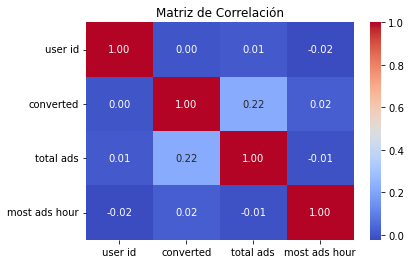

In [27]:
correlacion_matrix = df_marketing.corr()
sns.heatmap(correlacion_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

#La gráfica representa el total de las relaciones de las variables

In [26]:
contingency_table = pd.crosstab(df_marketing['test group'], df_marketing['converted'])
chi2, p_chi2, _, _ = chi2_contingency (contingency_table)
print(f"Prueba de Chi-cuadrado - p-valor: {p_chi2}")

Prueba de Chi-cuadrado - p-valor: 1.9989623063390075e-13


In [25]:
control_group = df_marketing[df_marketing['test group'] == 'ad']
test_group = df_marketing[df_marketing['test group'] == 'psa']
t_stat, p_ttest = ttest_ind(control_group['converted'], test_group['converted'])
print(f"Prueba t para converted entre Control y Test - p-valor: {p_ttest}")

Prueba t para converted entre Control y Test - p-valor: 1.7033052627831264e-13


Se rechaza la hipotesis nula, por tanto existen diferencias significativas en la tasa de conversión de los grupos.

Conclusiones y recomendaciones: Basándote en los resultados de la prueba de hipótesis, llega a una conclusión sobre si el nuevo diseño de anuncio es más efectivo en la conversión de usuarios que el diseño anterior. Si es así, puedes hacer recomendaciones basadas en estos hallazgos.